# Constructed Attributes and Model Defaults

In [1]:
import numpy as np
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

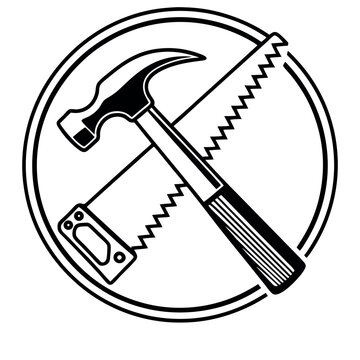

In [2]:
from IPython import display

display.Image("../../docs/images/constructors_thumbnail.jpg", width=200)

In the other introductory notebooks, there were repeated references to default parameters and constructed inputs. What's up with that? Read on for the answers!

## Just Gimme Whatever: Default AgentType Options

Each `AgentType` subclass, like `PerfForesightConsumerType` and `IndShockConsumerType`, has a dictionary called `default_` as a class attribute. It (usually) has three entries: `params`, `solver`, and `model`. The `solver` entry has a reference to the function that solves the one-period problem for the model (conditional on the solution to the succeeding period and the parameters for that period). The `model` entry is a reference to a filename that is used for the new, developmental simulation structure. Finally, the `params` entry has a reference to a dictionary of default model parameters, which is usually defined *just above* the class definition.

If you do not want to use the default parameters (including constructors), pass `use_defaults=False` to the `AgentType` subclass when you make an instance. This means that you must pass all required parameters (and constructors) explicitly, or the instance won't be able to `solve` its model-- or do much of anything.

In [3]:
NoDefaultExample = IndShockConsumerType(
    use_defaults=False
)  # Has a solver, but no parameters at all!

### Changing Parameter Values

Whenever you make a new instance of an `AgentType` subclass, you can pass as many arguments as you would like (in a dictionary or otherwise), but they must all be keyword arguments (e.g. `MyType = IndShockConsumerType('CRRA' = 3.0)`, but not `MyType = IndShockConsumerType(3.0)`. Arguments that are explicitly passed will supercede any default value for that parameter. For any parameters that you *don't* pass, the value in the default dictionary will be used instead.

For most `AgentType` subclasses, the default parameters include `T_cycle=1` and `cycles=1`. Thus if you make an instance of that class using only default parameters (no arguments passed), it will represent an agent that lives for only one non-trivial period. That's not very interesting, but it *is* a model! These simple defaults were chosen so that it's fast and easy to make *some* instance of each class, if only so that the user can investigate what's inside it.

The primary exception to the convention that default parameters have `cycles=1` are models for which there is no meaningful interpretation to a finite horizon model. This includes the `TractableBufferStockConsumerType`, which is by defintion infinite horizon (and uses a much different solution method than other HARK models) and the `RepresentativeAgentConsumerType`.

If you are exploring an `AgentType` subclass and want it to do something more interesting, the simplest approach is to set `cycles=0` and then `solve()` your instance. This will solve the *infinite horizon* model with default parameters. Alternatively, set `cycles>1` to solve several non-terminal (or non-trivial) periods.

### Style Conventions for Default Parameters

To the greatest extent possible, we have tried to make all default parameters be single numbers, or a list with a single number. For anything more complex than that, there should be a **constructor** function (see below) to build the more complicated object.

In some cases, it would be awkward or impossible to specify simple parameters, and a larger object needs to be passed as arguments to an `AgentType` subclass's initializer. That's fine, and we do it too in our projects! The most common situation for this is when some model inputs have been pre-computed-- maybe in an earlier phase of this project, or maybe the results from someone else's project. This might be a life-cycle sequence of parameters estimated in reduced form, or transition probabilities among discrete states. In these situations, we recommend that your project have a `Parameters.py` file where you do the work of reading in this outside data and constructing the parameter dictionary you want to use.

## Constructor Functions for Complex Model Inputs

Some objects needed to solve a model are complex, but can be created based on simpler "primitive" parameters. This includes the lifecycle sequence of income shock distributions, a parameterizable Markov transition matrix among discrete states, or age-dependent mortality probabilities that can be characterized with polynomial coefficients.

HARK can automatically build these objects using constructor functions. Such functions are specified in each instance's `constructors` dictionary, which can be passed like any other object at initialization. Each `AgentType` has default constructors for some model objects, which are listed in the `constructors` entry of its default parameter dictionary.

You do not need to worry about the "order" in which constructors are defined in the dictionary. The `construct` method automatically works out any dependencies among constructed attributes, constructing "lower level" objects before it builds "higher level" ones that depend on intermediate objects.

### Viewing Constructors

The easiest way to see how an `AgentType` subclass's (default) constructors are set up is to use the `describe_constructors` method. Simply make a default instance of the class and run the method, like so:

In [4]:
ThisType = IndShockConsumerType()  # no parameters, only defaults
ThisType.describe_constructors()  # no arguments

✓ kNrmInitDstn : make_lognormal_kNrm_init_dstn
    ✓ kLogInitMean
    ✓ kLogInitStd
    ✓ kNrmInitCount
    ✓ RNG
✓ pLvlInitDstn : make_lognormal_pLvl_init_dstn
    ✓ pLogInitMean
    ✓ pLogInitStd
    ✓ pLvlInitCount
    ✓ RNG
✓ IncShkDstn : construct_lognormal_income_process_unemployment
    ✓ T_cycle
    ✓ PermShkStd
    ✓ PermShkCount
    ✓ TranShkStd
    ✓ TranShkCount
    ✓ T_retire
    ✓ UnempPrb
    ✓ IncUnemp
    ✓ UnempPrbRet
    ✓ IncUnempRet
    ✓ RNG
    ✓ neutral_measure
✓ PermShkDstn : get_PermShkDstn_from_IncShkDstn
    ✓ IncShkDstn
    ✓ RNG
✓ TranShkDstn : get_TranShkDstn_from_IncShkDstn
    ✓ IncShkDstn
    ✓ RNG
✓ aXtraGrid : make_assets_grid
    ✓ aXtraMin
    ✓ aXtraMax
    ✓ aXtraCount
    ✓ aXtraExtra
    ✓ aXtraNestFac
✓ solution_terminal : make_basic_CRRA_solution_terminal
    ✓ CRRA



This prints to screen a summary of constructed objects. The unindented lines name attributes of this instance that are constructed, with the name of the constructor function after the colon. The indented lines following each constructed attribute name list the names of the arguments for that function; when the constructor function is run, those arguments are pulled from the instance's attributes. Note that those constructor arguments could be parameters that were passed at instantiation (or default parameters), or they might be *other* constructed objects.

Each line of the output of `describe_constructors` will begin with one of three symbols: a check mark, an X, or a star. Unindented lines naming constructed objects can only begin with a check mark or X. These are shorthand for the following:

- $\surd$ : Constructed object was successfully built, or named input exists as attribute of agent.
- $X$ : Constructed object was not built, or named input was not found as attribute of agent.
- $*$ : Input was not found as attribute of agent, but constructor function has a default value for it.

A constructed attribute could fail to build for any one of several reasons:

1. No proper constructor was found (the entry in the `constructors` dictionary is not a function)
2. At least one required input was not found
3. The constructor function encountered an error during execution

### Updating Constructed Attributes

If you change (after instantiation) the value of a parameter that a constructed attribute was based on, this does *not* update the content of the constructed attribute. You must explicitly tell HARK to do so by using the `update` or `construct` method, which are redundant "synonym" methods.

The safest thing to do after changing one or more parameters is to simply invoke the `construct` method with no arguments. This will re-run all constructors, starting from scratch and re-resolving all dependencies. Data will never be "lost" in this process; if a constructor function fails, the method will restore the attribute to its state before the call to `construct`.

In [5]:
ThisType = IndShockConsumerType(PermShkCount=5)
print("Made a new instance of the agents.")
print(
    "Standard deviation of log permanent income shocks is " + str(ThisType.PermShkStd)
)
print(
    "Permanent income shock equiprobable values: "
    + str(ThisType.PermShkDstn[0].atoms[0])
)
ThisType.assign_parameters(PermShkStd=[0.15])
print("Changed permanent shock standard deviation.")
print(
    "Standard deviation of log permanent income shocks is " + str(ThisType.PermShkStd)
)
print(
    "Permanent income shock equiprobable values: "
    + str(ThisType.PermShkDstn[0].atoms[0])
)
ThisType.update()
print("Rebuilt all constructed attributes.")
print(
    "Permanent income shock equiprobable values: "
    + str(ThisType.PermShkDstn[0].atoms[0])
)

Made a new instance of the agents.
Standard deviation of log permanent income shocks is [0.1]
Permanent income shock equiprobable values: [0.86596649 0.94360411 0.99511802 1.04951926 1.14579214]
Changed permanent shock standard deviation.
Standard deviation of log permanent income shocks is [0.15]
Permanent income shock equiprobable values: [0.86596649 0.94360411 0.99511802 1.04951926 1.14579214]
Rebuilt all constructed attributes.
Permanent income shock equiprobable values: [0.80345582 0.91327642 0.98904903 1.07128067 1.22293806]


If you know which attributes need to be updated, or want to restrict what is done for some reason, pass the names of those attributes as strings to `construct` or `update`; all other constructed attributes will be ignored. In the example below, we tell the agent to rebuild its `IncShkDstn` attribute only, but *not* `PermShkDstn`, which is based on `IncShkDstn`. We don't know why you would do this, but it's just an example!

In [6]:
ThisType = IndShockConsumerType(PermShkCount=5)
print(
    "Standard deviation of log permanent income shocks is " + str(ThisType.PermShkStd)
)
print(
    "Permanent income shock equiprobable values: "
    + str(ThisType.PermShkDstn[0].atoms[0])
)
ThisType.assign_parameters(PermShkStd=[0.15])
print("Changed permanent shock standard deviation.")
ThisType.update("IncShkDstn")
print("Rebuilt only IncShkDstn attribute.")
print(
    "Permanent income shock equiprobable values in PermShkDstn: "
    + str(ThisType.PermShkDstn[0].atoms[0])
)
print(
    "Permanent income shock equiprobable values in IncShkDstn: "
    + str(np.unique(ThisType.IncShkDstn[0].atoms[0]))
)

Standard deviation of log permanent income shocks is [0.1]
Permanent income shock equiprobable values: [0.86596649 0.94360411 0.99511802 1.04951926 1.14579214]
Changed permanent shock standard deviation.
Rebuilt only IncShkDstn attribute.
Permanent income shock equiprobable values in PermShkDstn: [0.86596649 0.94360411 0.99511802 1.04951926 1.14579214]
Permanent income shock equiprobable values in IncShkDstn: [0.80345582 0.91327642 0.98904903 1.07128067 1.22293806]


### Options for Debugging Constructors

Sometimes, especially when making a new `AgentType` subclass or programming a new constructor, things just *don't work* like you expected. Suppose you try to instantiate your agents, and the `__init__` method encounters an error when constructing attributes. Now you don't even have an instance of your class to *look at* and see what went wrong. You could turn on a debugging utility and investigate the state just before the error, but HARK has some other options.

When you make a new instance of an `AgentType` subclass, you can pass the argument `construct=False` to simply *skip* the attribute construction step. The class will instantiate without trying to build *anything*. It probably won't be able to `solve` its model, but at least it exists!

In conjunction with the `describe_constructors` method, this is a quick way of seeing whether your parameter dictionary is missing any required values, like so:

In [7]:
AnotherType = IndShockConsumerType(construct=False)
AnotherType.describe_constructors()

X kNrmInitDstn : make_lognormal_kNrm_init_dstn
    ✓ kLogInitMean
    ✓ kLogInitStd
    ✓ kNrmInitCount
    ✓ RNG
X pLvlInitDstn : make_lognormal_pLvl_init_dstn
    ✓ pLogInitMean
    ✓ pLogInitStd
    ✓ pLvlInitCount
    ✓ RNG
X IncShkDstn : construct_lognormal_income_process_unemployment
    ✓ T_cycle
    ✓ PermShkStd
    ✓ PermShkCount
    ✓ TranShkStd
    ✓ TranShkCount
    ✓ T_retire
    ✓ UnempPrb
    ✓ IncUnemp
    ✓ UnempPrbRet
    ✓ IncUnempRet
    ✓ RNG
    ✓ neutral_measure
X PermShkDstn : get_PermShkDstn_from_IncShkDstn
    X IncShkDstn
    ✓ RNG
X TranShkDstn : get_TranShkDstn_from_IncShkDstn
    X IncShkDstn
    ✓ RNG
X aXtraGrid : make_assets_grid
    ✓ aXtraMin
    ✓ aXtraMax
    ✓ aXtraCount
    ✓ aXtraExtra
    ✓ aXtraNestFac
✓ solution_terminal : make_basic_CRRA_solution_terminal
    ✓ CRRA



In this simple case with default parameters, we see that most of the necessary constructor arguments are present, but essentially no constructed attributes exist. The only one that does is `solution_terminal`, and it's just the dummy default, not the *actual* terminal period solution.

In [8]:
print(
    AnotherType.solution_terminal
)  # NullFunc is a fake function that returns NaNs no matter what

One constructor input is missing... but it's `IncShkDstn`, itself a constructed attribute (that was not constructed).

At this point, you could run the constructor methods one by one to see where things go wrong. In this case, they *won't* go wrong:

In [9]:
AnotherType.construct("aXtraGrid")
AnotherType.construct(
    "pLvlInitDstn", "kNrmInitDstn"
)  # can pass multiple attribute names
AnotherType.construct("IncShkDstn")
AnotherType.construct("PermShkDstn", "TranShkDstn")
AnotherType.construct("solution_terminal")

But what if things *do* go wrong, what then? The `construct` method has an option to see what (if anything) went wrong with each constructor. If you pass the argument `force=True` to `construct` or `update`, it will "force" its way through any errors, trying to do as much as it can. While it does so, the method stores error messages and information about missing constructor arguments.

This error information can be found in the attributes `_missing_key_data` (a list of attribute-argument pairs for missing arguments) and `_constructor_errors` (a dictionary of error messages). Consider this example:

In [10]:
BrokenType = IndShockConsumerType(construct=False)  # don't make anything at first
BrokenType.assign_parameters(
    PermShkCount="eh, Steve!"
)  # this is supposed be a whole number
BrokenType.construct(force=True)  # head down, power through
BrokenType.describe_constructors()

✓ kNrmInitDstn : make_lognormal_kNrm_init_dstn
    ✓ kLogInitMean
    ✓ kLogInitStd
    ✓ kNrmInitCount
    ✓ RNG
✓ pLvlInitDstn : make_lognormal_pLvl_init_dstn
    ✓ pLogInitMean
    ✓ pLogInitStd
    ✓ pLvlInitCount
    ✓ RNG
X IncShkDstn : construct_lognormal_income_process_unemployment
    ✓ T_cycle
    ✓ PermShkStd
    ✓ PermShkCount
    ✓ TranShkStd
    ✓ TranShkCount
    ✓ T_retire
    ✓ UnempPrb
    ✓ IncUnemp
    ✓ UnempPrbRet
    ✓ IncUnempRet
    ✓ RNG
    ✓ neutral_measure
X PermShkDstn : get_PermShkDstn_from_IncShkDstn
    X IncShkDstn
    ✓ RNG
X TranShkDstn : get_TranShkDstn_from_IncShkDstn
    X IncShkDstn
    ✓ RNG
✓ aXtraGrid : make_assets_grid
    ✓ aXtraMin
    ✓ aXtraMax
    ✓ aXtraCount
    ✓ aXtraExtra
    ✓ aXtraNestFac
✓ solution_terminal : make_basic_CRRA_solution_terminal
    ✓ CRRA



As expected, it failed to build anything that depends on `PermShkCount`, which has the not-very-useful value of `"eh, Steve!"`. We can see how the `IncShkDstn` constructor failed by looking at its entry in `_constructor_errors`:

In [11]:
print(BrokenType._constructor_errors["IncShkDstn"])

<class 'TypeError'>: 'str' object cannot be interpreted as an integer


Indeed it cannot. We can also see that the constructors for `PermShkDstn` and `TranShkDstn` failed because their constructors couldn't find the required input `IncShkDstn`:

In [12]:
print(BrokenType._missing_key_data)

[('PermShkDstn', 'IncShkDstn'), ('TranShkDstn', 'IncShkDstn')]


This same information about missing arguments is available in a different form in `_constructor_errors`:

In [13]:
print(BrokenType._constructor_errors["PermShkDstn"])
print(BrokenType._constructor_errors["TranShkDstn"])

Missing required arguments: IncShkDstn
Missing required arguments: IncShkDstn


### Using Non-Default Constructors

Each `AgentType` comes with a default set of constructors, but you can easily swap these out (or add new ones for other attributes) on an instance-by-instance basis. This can be done at instantiation (by passing a parameter dictionary with a `constructors` entry) or by changing constructors *after* instantiation (and then re-running `construct` or `update`).

The default constructor for `aXtraGrid` is called `make_assets_grid`, which makes a multi-exponentially nested grid, with some additional options. Let's replace this with our own custom function using some different arguments.

In [14]:
# Define a new constructor function for aXtraGrid
def make_other_assets_grid(aXtraMin, aXtraMax, aXtraCount, aXtraOrder):
    """
    Make a grid spaced on [aXtraMin,aXtraMax] with spacing of the chosen polynomial order.
    """
    base_grid = np.linspace(0.0, 1.0, aXtraCount) ** aXtraOrder
    out_grid = aXtraMin + (aXtraMax - aXtraMin) * base_grid
    return out_grid

In [15]:
# Make a new instance of our AgentType subclass using this constructor
SpecialType = IndShockConsumerType(
    constructors={
        "aXtraGrid": make_other_assets_grid
    },  # put a dictionary here to replace default constructors
    aXtraOrder=2.5,  # also pass this new required parameter
)

In [16]:
# Compare aXtraGrids between the original version and our new special constructor
print("The class default has an aXtraGrid of:")
print(ThisType.aXtraGrid)
print("The example with a custom constructor has an aXtraGrid of:")
print(SpecialType.aXtraGrid)

The class default has an aXtraGrid of:
[1.00000000e-03 2.01713727e-02 4.04645973e-02 6.19689346e-02
 8.47826891e-02 1.09014323e-01 1.34783729e-01 1.62223697e-01
 1.91481594e-01 2.22721307e-01 2.56125489e-01 2.91898165e-01
 3.30267760e-01 3.71490637e-01 4.15855231e-01 4.63686907e-01
 5.15353678e-01 5.71272965e-01 6.31919613e-01 6.97835428e-01
 7.69640582e-01 8.48047286e-01 9.33876256e-01 1.02807664e+00
 1.13175022e+00 1.24618095e+00 1.37287121e+00 1.51358644e+00
 1.67041051e+00 1.84581461e+00 2.04274370e+00 2.26472534e+00
 2.51600777e+00 2.80173618e+00 3.12817922e+00 3.50302228e+00
 3.93574988e+00 4.43814835e+00 5.02497206e+00 5.71483401e+00
 6.53140746e+00 7.50506263e+00 8.67511887e+00 1.00929770e+01
 1.18265253e+01 1.39664114e+01 1.66350835e+01 2.00000000e+01]
The example with a custom constructor has an aXtraGrid of:
[1.00000000e-03 2.32057672e-03 8.47031001e-03 2.15857537e-02
 4.32584549e-02 7.48224826e-02 1.17450608e-01 1.72201961e-01
 2.40049920e-01 3.21900142e-01 4.18603025e-01 5

Notice that both the default grid and the one that we just produced have the same number of nodes and the same maximum and minimum. That's because we used the *same* parameter names for `aXtraCount`, `aXtraMin`, and `aXtraMax`, so our custom constructor can draw on the default parameter values. That is, we specified the new `aXtraOrder` parameter, but *not* the other three when instantiating `SpecialType`.

### Special Constructors

There is one special case constructor, called `get_it_from` (which can be imported from `HARK.utilities`). In some cases, multiple model objects are "naturally" constructed jointly-- maybe even there's no way to make one without the other. But HARK's constructor architecture assumes that each constructor function has *one* output, which is assigned to the attribute named in the `constructors` dictionary key.

In this situation, you can write one constructor function, which should construct and return a dictionary of multiple model objects. The keys of this dictionary should be the names of the attributes that it constructed. Put this "multiple constructor" into the `constructors` dictionary, assigned to an arbitrary (but unique) name. For example, if there were several income process objects that were constructed together, the `constructors` dictionary might have the entry `"income_process_stuff" : make_AR1_markov_array_and_pLvlGrid`.

The `constructors` dictionary should also have entries for the individual constructed objects, with a value of `get_it_from("dict_name")`. In the example above, we might have `pLvlMrkvArray : get_it_from("income_process_stuff")` and `pLvlGrid : get_it_from("income_process_stuff")`.